In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import numpy
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

sns.set_style('white', {'legend.frameon':True})
mpl.rcParams['figure.figsize'] = 25, 10

In [2]:
trenovacie = pd.read_csv("data/predspracovane_train.csv")


In [3]:
trenovacie['class'].unique()

array(['negative', 'increased binding protein',
       'decreased binding protein'], dtype=object)

In [4]:
overovacie = pd.read_csv("data/predspracovane_valid.csv")
testovacie = pd.read_csv("data/predspracovane_test.csv")


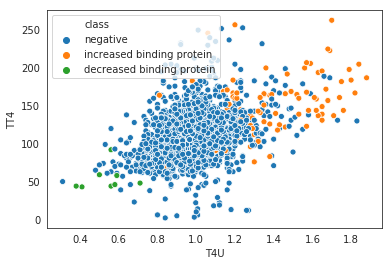

In [5]:
sns.scatterplot('T4U', 'TT4', data=trenovacie[['T4U', 'TT4', 'class']], hue='class')

Pre manualne pravidla rozhodovania sme zvolili atributy T4U a TT4. Podla scatterplotu vidno, ze maju vplyv na class. Increased binding protein bude ked je T4U viac ako 1.2 alebo TT4 viac ako 172. Decreased ak je T4U menej ako 0.7 alebo TT4 menej ako 50. V ostatnych pripadoch je negative.

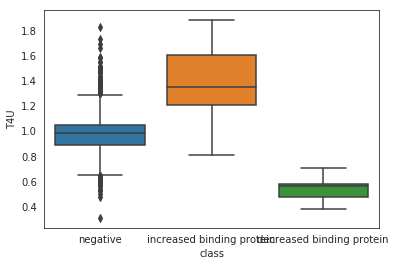

In [6]:
sns.boxplot('class', 'T4U', data=trenovacie)

Na pravidlo podla jedneho atributu sme zvolil T4U, lebo sa zda mat najmenej prekryvajucich sa hodnot. Hranica medzi Increased binding protein a negative je T4U=1,1, medzi Decreased binding protein a negative je T4U=0.7

In [7]:
porovnanie_vysledkov = pd.DataFrame({'Sposob': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1 macro': []})

In [8]:
def podla_testyriu(data):
    vysledok = []
    for zaznam in data['T4U']:
        if zaznam < 0.7:
            vysledok.append('decreased binding protein')
        elif zaznam > 1.1:
            vysledok.append('increased binding protein')
        else:
            vysledok.append('negative')
            
    return vysledok


manualna_jeden = podla_testyriu(overovacie)
# VYPIS METRIK PRE MANUALNE PRAVIDLA S JEDNYM ATRIBUTOM
a = accuracy_score(overovacie['class'], manualna_jeden)
p = precision_score(overovacie['class'], manualna_jeden, average='macro')
r = recall_score(overovacie['class'], manualna_jeden, average='macro')
f = f1_score(overovacie['class'], manualna_jeden, average='macro')
print('Accuracy \t: ' + str(a))
print('Precision\t: ' + str(p))
print('Recall \t: ' + str(r))
print('Efjednicka\t: ' + str(f))
porovnanie_vysledkov = porovnanie_vysledkov.append({'Sposob': 'Manualne pravidlo T4U', 'accuracy': a, 'precision': p, 'recall': r, 'f1 macro': f}, ignore_index=True)


Accuracy 	: 0.8065843621399177
Precision	: 0.428111620087498
Recall 	: 0.907515923566879
Efjednicka	: 0.46278112954583545


In [9]:
def podla_testyriuaajtetestyritamdajmenechjesranda(data):
    vysledok = []
    for testyriu, tetestyri in data[['T4U', 'TT4']].values:
        if testyriu > 1.2 or tetestyri > 172:
            vysledok.append('increased binding protein')
        elif testyriu < 0.7 or tetestyri < 50:
            vysledok.append('decreased binding protein')
        else:
            vysledok.append('negative')
            
    return vysledok


manualna_dva = podla_testyriuaajtetestyritamdajmenechjesranda(overovacie)
# VYPIS METRIK PRE MANUALNE PRAVIDLA S DVOMA ATRIBUTMI
a = accuracy_score(overovacie['class'], manualna_dva)
p = precision_score(overovacie['class'], manualna_dva, average='macro')
r = recall_score(overovacie['class'], manualna_dva, average='macro')
f = f1_score(overovacie['class'], manualna_dva, average='macro')
print('Accuracy \t: ' + str(a))
print('Precision\t: ' + str(p))
print('Recall \t: ' + str(r))
print('Efjednicka\t: ' + str(f))
porovnanie_vysledkov = porovnanie_vysledkov.append({'Sposob': 'Manualne pravidlo T4U+TT4', 'accuracy': a, 'precision': p, 'recall': r, 'f1 macro': f}, ignore_index=True)

Accuracy 	: 0.8621399176954733
Precision	: 0.43110705233427565
Recall 	: 0.9006652512384997
Efjednicka	: 0.4747719374812025


Tieto dve pravidla maju podobnu uspesnost, pravdepodobne preto, lebo T4U a TT4 koreluju a teda tam dalsi atribut neprida dodatocnu informaciu.

In [10]:
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import *

stlpce_na_zakodovanie = ['FTI measured', 'education', 'lithium', 'on thyroxine', 'tumor', 'relationship',
                         'thyroid surgery', 'workclass', 'I131 treatment', 'marital-status', 'goitre',
                         'native-country', 'hypopituitary', 'query on thyroxine', 'T3 measured', 'referral source',
                         'occupation', 'TBG measured', 'race', 'pregnant', 'TSH measured', 'query hyperthyroid',
                         'TT4 measured', 'on antithyroid medication', 'sick', 'T4U measured', 'psych',
                         'query hypothyroid', 'sex']

kodovace = {}
for stlpec in stlpce_na_zakodovanie:
    kodovace[stlpec] = LabelEncoder()
    kodovace[stlpec].fit(trenovacie[stlpec].append(overovacie[stlpec]).append(testovacie[stlpec])) #data su spojene nech sa kodovac dozvie o vsetkych moznych hodnotach


def transformuj(co):
    vystup = co.copy()
    for ss in stlpce_na_zakodovanie:
        try:
            vystup[ss] = kodovace[ss].transform(vystup[ss])
        except ValueError:
            print("CHYBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA" + ss)
    return vystup


# Vytvorenie a naucenie OneHotEncoderov
skorozakodovane = transformuj(trenovacie).drop(['class', 'date_of_birth', 'name', 'address'], axis=1)
trafo = make_column_transformer(
    (list(set(list(skorozakodovane.columns)) - set(stlpce_na_zakodovanie)), "passthrough"),
    (stlpce_na_zakodovanie, OneHotEncoder(categories='auto', handle_unknown='ignore')))
trafo.fit(skorozakodovane)


def zakoduj(vstup):
    data = pd.DataFrame(vstup)
    vystup = pd.DataFrame(trafo.transform(transformuj(data).drop(['class', 'date_of_birth', 'name', 'address'], axis=1)).toarray())
    vystup['class'] = vstup['class']
    return vystup

zakodovane_trenovacie = zakoduj(trenovacie)
zakodovane_overovacie = zakoduj(overovacie)

In [11]:
def natrenuj(klasifikator, data, podla_stlpcov=[]):
    X = data[podla_stlpcov] if podla_stlpcov else data.select_dtypes(numpy.number) 
    # v zakodovanych datach su (temer) vsetky atributy numericke takze ked vezmeme vsetky numericke tak je dobre
    y = data['class']
    klasifikator.fit(X, y)


klasifikator_vsetkeho = DecisionTreeClassifier(criterion='entropy')
natrenuj(klasifikator_vsetkeho, zakodovane_trenovacie)
pred = klasifikator_vsetkeho.predict(zakodovane_overovacie.drop('class', axis=1))
a = accuracy_score(zakodovane_overovacie['class'], pred)
p = precision_score(zakodovane_overovacie['class'], pred, average='macro')
r = recall_score(zakodovane_overovacie['class'], pred, average='macro')
f = f1_score(zakodovane_overovacie['class'], pred, average='macro')
porovnanie_vysledkov = porovnanie_vysledkov.append({'Sposob': 'Strom so vsetkymi atr.', 'accuracy': a, 'precision': p, 'recall': r, 'f1 macro': f}, ignore_index=True)
print('Accuracy \t: ' + str(a))
print('Precision\t: ' + str(p))
print('Recall \t: ' + str(r))
print('Efjednicka\t: ' + str(f))
dolezitost = pd.DataFrame({'Feature': zakodovane_trenovacie.select_dtypes(numpy.number).columns, 'Importance': klasifikator_vsetkeho.feature_importances_})
dolezitost.sort_values(by='Importance', ascending=False).head(15)

Accuracy 	: 0.9691358024691358
Precision	: 0.7099058380414313
Recall 	: 0.6217126680820949
Efjednicka	: 0.6546977730646871


,Feature,Importance
6,6,0.456248
0,0,0.213060
3,3,0.084081
10,10,0.037173
1,1,0.028931
39,39,0.025974
11,11,0.023341
8,8,0.021169
108,108,0.020701
47,47,0.015339


Pri trenovani stromu so vsetkymi atributmi (okrem adresy, mena a datumu narodenia) s one-hot encodovanymi kategorickymi atributmi sa ako najdolezitejsie atributy ukazali T4U, T3, TT4 a TSH (zistene, ked sme na OneHotEncoding este pouzivali pd.getDummies co sa ale neskor ukazalo ako problem)

In [12]:
def testy_hlbok(trenovacie, overovacie, stlpce=[], klasifikator=DecisionTreeClassifier(criterion='entropy')):
    X_train = trenovacie[stlpce] if stlpce else trenovacie.select_dtypes(numpy.number)
    y_train = trenovacie['class']
    results = []
    X_test = overovacie[stlpce] if stlpce else overovacie.select_dtypes(numpy.number)
    y_test = overovacie['class']
    # print(len(X_train.columns))
    # print(len(X_test.columns))
    for i in X_train.columns: 
        if i not in X_test.columns:
            print(i)
    estimators = []
    for i in range(1, 20):
        row = {'model_complexity': i}
        
        clf = klasifikator
        clf.max_depth = i
    
        pred = clf.fit(X_train, y_train).predict(X_train)
        row['train_accuracy'] = accuracy_score(y_train, pred)
        row['train_f1'] = f1_score(y_train, pred, average='macro')
    
        pred = clf.predict(X_test)
        row['valid_accuracy'] = accuracy_score(y_test, pred)
        row['valid_f1'] = f1_score(y_test, pred, average='macro') 
        results.append(row)
        estimators.append(clf)
        
    return results

In [13]:
zlozitosti_na_vsetkom = pd.DataFrame(testy_hlbok(zakodovane_trenovacie, zakodovane_overovacie, klasifikator=klasifikator_vsetkeho))
zlozitosti_na_vsetkom

/usr/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-s

,model_complexity,train_accuracy,train_f1,valid_accuracy,valid_f1
0,1,0.954566,0.325585,0.969136,0.328109
1,2,0.969252,0.534461,0.969136,0.504132
2,3,0.969252,0.547640,0.959877,0.476945
3,4,0.977972,0.831476,0.973251,0.709294
4,5,0.988527,0.949269,0.975309,0.762434
5,6,0.993575,0.972365,0.974280,0.706700
6,7,0.997705,0.990590,0.971193,0.734069
7,8,1.000000,1.000000,0.970165,0.710427
8,9,1.000000,1.000000,0.974280,0.745254
9,10,1.000000,1.000000,0.975309,0.749298


Klasifikator nad vsetkymi atributmi sa ocividne pretrenoval, kedze na trenovacej sade ma 100% uspesnost a na validacnej o takmer 30 percentualnych bodov nizsiu.

In [14]:
pocet_neg = trenovacie[trenovacie['class'] == 'negative'].count()
pocet_inc = trenovacie[trenovacie['class'] == 'increased binding protein'].count()
pocet_dec = trenovacie[trenovacie['class'] == 'decreased binding protein'].count()

klasifikator_vahy = DecisionTreeClassifier(criterion='entropy', class_weight='balanced') # klasifikator vyvazuje pocty tried
natrenuj(klasifikator_vahy, zakodovane_trenovacie)
pred = klasifikator_vahy.predict(zakodovane_overovacie.drop('class', axis=1))
a = accuracy_score(zakodovane_overovacie['class'], pred)
p = precision_score(zakodovane_overovacie['class'], pred, average='macro')
r = recall_score(zakodovane_overovacie['class'], pred, average='macro')
f = f1_score(zakodovane_overovacie['class'], pred, average='macro')
porovnanie_vysledkov = porovnanie_vysledkov.append({'Sposob': 'Strom s "balanced" triedami', 'accuracy': a, 'precision': p, 'recall': r, 'f1 macro': f}, ignore_index=True)
print('Accuracy \t: ' + str(a))
print('Precision\t: ' + str(p))
print('Recall \t: ' + str(r))
print('Efjednicka\t: ' + str(f))

Accuracy 	: 0.9567901234567902
Precision	: 0.5705488833630202
Recall 	: 0.7356970983722576
Efjednicka	: 0.6302959081929039


In [15]:

zlozitosti_na_vsetkom = pd.DataFrame(testy_hlbok(zakodovane_trenovacie, zakodovane_overovacie, klasifikator=klasifikator_vahy))
zlozitosti_na_vsetkom


/usr/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,model_complexity,train_accuracy,train_f1,valid_accuracy,valid_f1
0,1,0.045434,0.107041,0.030864,0.085516
1,2,0.876090,0.556476,0.825103,0.452224
2,3,0.849013,0.544571,0.800412,0.444397
3,4,0.912804,0.813796,0.884774,0.554578
4,5,0.929325,0.834408,0.891975,0.551865
5,6,0.945388,0.858401,0.901235,0.553895
6,7,0.988068,0.955422,0.956790,0.637535
7,8,0.988527,0.957727,0.951646,0.615638
8,9,0.995411,0.981836,0.955761,0.625631
9,10,0.996329,0.985323,0.955761,0.625631


Tento pokus kde sme urcili vahy jednotlivych tried ako 'balanced' dopadol este horsie.

In [16]:
cls = DecisionTreeClassifier(criterion='entropy', max_depth=5)
X = trenovacie[['TT4', 'T4U', 'T3']]
y = trenovacie['class']
cls.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [17]:
pred = cls.predict(overovacie[['TT4', 'T4U', 'T3']])

In [18]:
a = accuracy_score(overovacie['class'], pred)
p = precision_score(overovacie['class'], pred, average='macro')
r = recall_score(overovacie['class'], pred, average='macro')
f = f1_score(overovacie['class'], pred, average='macro')
porovnanie_vysledkov = porovnanie_vysledkov.append({'Sposob': 'Strom s manualnym vyberom atr.', 'accuracy': a, 'precision': p, 'recall': r, 'f1 macro': f}, ignore_index=True)
print('Accuracy \t: ' + str(a))
print('Precision\t: ' + str(p))
print('Recall \t: ' + str(r))
print('Efjednicka\t: ' + str(f))


Accuracy 	: 0.9742798353909465
Precision	: 0.7668008588298442
Recall 	: 0.7027742392073603
Efjednicka	: 0.731694930224342


In [19]:
complexity_df = pd.DataFrame(testy_hlbok(trenovacie, overovacie, ['TT4', 'T4U', 'T3']))
complexity_df.head(10)

/usr/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-s

,model_complexity,train_accuracy,train_f1,valid_accuracy,valid_f1
0,1,0.954566,0.325585,0.969136,0.328109
1,2,0.969252,0.534461,0.969136,0.504132
2,3,0.969252,0.534461,0.969136,0.504132
3,4,0.973382,0.792936,0.974280,0.699469
4,5,0.980725,0.857722,0.973251,0.727831
5,6,0.984855,0.935905,0.968107,0.779087
6,7,0.988986,0.950464,0.970165,0.759485
7,8,0.992657,0.968417,0.970165,0.749179
8,9,0.994493,0.976052,0.970165,0.749179
9,10,0.996788,0.986107,0.969136,0.745866


Klasifikator s rucne vybranymi troma atributmi podla prieskumnej analyzy dosiahol mierne lepsie vysledky.

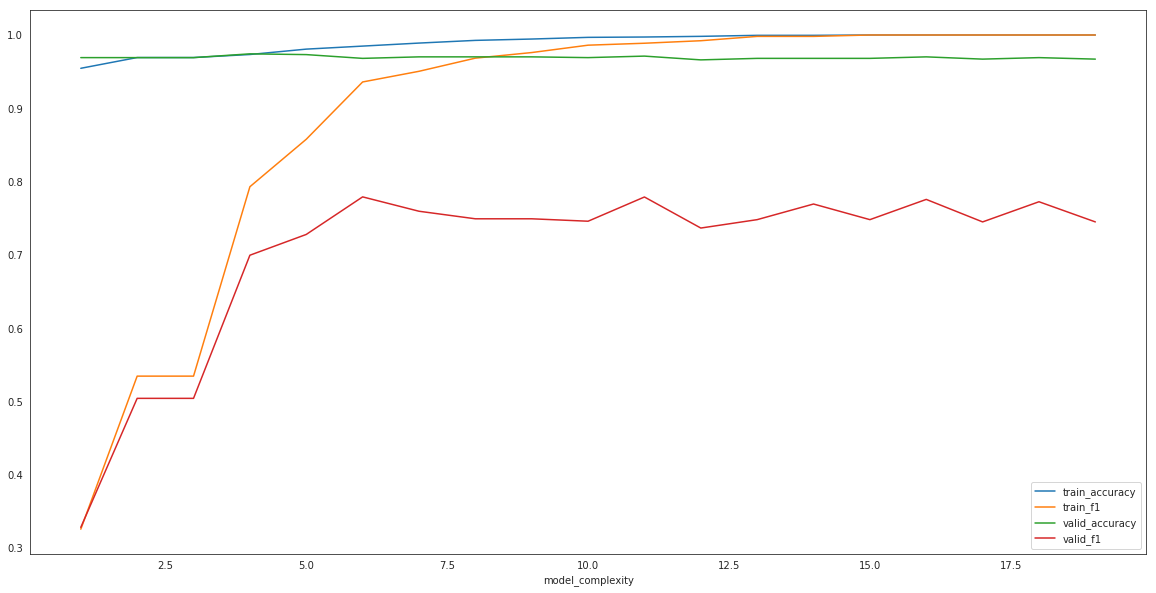

In [20]:
complexity_df.plot(x='model_complexity', figsize=(20, 10))

In [21]:
porovnanie_vysledkov

,Sposob,accuracy,precision,recall,f1 macro
0,Manualne pravidlo T4U,0.806584,0.428112,0.907516,0.462781
1,Manualne pravidlo T4U+TT4,0.862140,0.431107,0.900665,0.474772
2,Strom so vsetkymi atr.,0.969136,0.709906,0.621713,0.654698
3,"Strom s ""balanced"" triedami",0.956790,0.570549,0.735697,0.630296
4,Strom s manualnym vyberom atr.,0.974280,0.766801,0.702774,0.731695


In [22]:
from sklearn.model_selection import GridSearchCV
clf = DecisionTreeClassifier

# cv_params = {'max_depth': list(range(1, 20, 2)), 'min_samples_split': list(range(2, 20, 2)), 'max_features': list(range(3, 60, 4)),
#              'class_weight': [
#                               {'negative': 1,'increased binding protein': 15, 'decreased binding protein': 20},
#                               {'negative': 1,'increased binding protein': 22, 'decreased binding protein': 260},
#                               {'negative': 1,'increased binding protein': 5, 'decreased binding protein': 10},
#                               {'negative': 1,'increased binding protein': 10, 'decreased binding protein': 15}]}
cv_params = {'max_depth': list(range(1, 20)), 'min_samples_leaf': list(range(1, 10))}
ind_params = {'random_state': 0}
optimization = GridSearchCV(clf(**ind_params),
                            cv_params,
                            scoring='f1_macro', cv=10, n_jobs=13, verbose=True)
X = zakodovane_trenovacie.drop('class', axis=1)
y = zakodovane_trenovacie['class']
optimization.fit(X, y)
# print(optimization.cv_results_)
print(optimization.best_estimator_)
print(optimization.best_score_)
pred = optimization.best_estimator_.predict(zakodovane_overovacie.drop('class', axis=1))
a = accuracy_score(zakodovane_overovacie['class'], pred)
p = precision_score(zakodovane_overovacie['class'], pred, average='macro')
r = recall_score(zakodovane_overovacie['class'], pred, average='macro')
f = f1_score(zakodovane_overovacie['class'], pred, average='macro')
porovnanie_vysledkov = porovnanie_vysledkov.append({'Sposob': 'Strom z GridSearch', 'accuracy': a, 'precision': p, 'recall': r, 'f1 macro': f}, ignore_index=True)
print('Accuracy \t: ' + str(a))
print('Precision\t: ' + str(p))
print('Recall \t: ' + str(r))
print('Efjednicka\t: ' + str(f))


Fitting 10 folds for each of 171 candidates, totalling 1710 fits


/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:626: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    1.1s
[Parallel(n_jobs=13)]: Done 505 tasks      | elapsed:    3.0s


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')
0.7404742505497752
Accuracy 	: 0.9722222222222222
Precision	: 0.7063949556430759
Recall 	: 0.7799433828733191
Efjednicka	: 0.736178481090212


[Parallel(n_jobs=13)]: Done 1710 out of 1710 | elapsed:    7.3s finished
/usr/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Iste zlepsenie sme dosiahli obmedzenim stromu do hlbky 8.
GridSearch nam ukazal, ze kriterium vyberu 'entropia' a tiez vaha tried 'balanced' sposobuje vyrazne pretrenovanie.
Manualne nastavenie vahy tried a pridavanie inych atributov len zhorsilo vysledky.

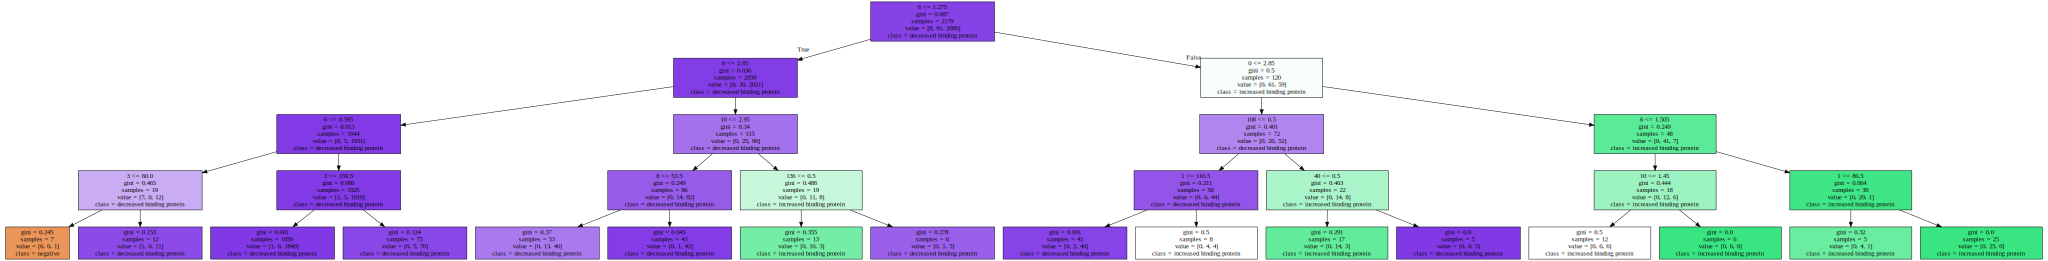

In [23]:
from sklearn.tree import export_graphviz
from graphviz import Source
from IPython.display import SVG

graph = Source(export_graphviz(optimization.best_estimator_,
                               out_file=None,
                               feature_names=zakodovane_trenovacie.drop('class', axis=1).columns,
                               class_names=zakodovane_trenovacie['class'].unique(),
                               filled = True))

display(SVG(graph.pipe(format='svg')))

In [26]:
porovnanie_vysledkov.head(20)

,Sposob,accuracy,precision,recall,f1 macro
0,Manualne pravidlo T4U,0.806584,0.428112,0.907516,0.462781
1,Manualne pravidlo T4U+TT4,0.862140,0.431107,0.900665,0.474772
2,Strom so vsetkymi atr.,0.969136,0.709906,0.621713,0.654698
3,"Strom s ""balanced"" triedami",0.956790,0.570549,0.735697,0.630296
4,Strom s manualnym vyberom atr.,0.974280,0.766801,0.702774,0.731695
5,Strom z GridSearch,0.972222,0.706395,0.779943,0.736178
